# Sample project: stock prediction and trading

What question you are looking to answer?
Why does this question matter?
What data did you use?
Where you got the data?
How was the data sampled?
How was the data obtained?
How did you explore the data?
How did you model the data?
Why you chose to model it that way?
What code did you write / use?
How did you fit the model?
How did you validated the model?
How you know the results make sense?
How did you visualized the results?
How you would communicate the results to others?
What did you learn?
What you would do differently if you did this project again?
If you were going to continue this work, what next steps you would take with this project?
How you would explain what you did to a data scientist?
How you would explain what you did to a non-data scientist?

## Improvements yet to be done

- Implement shorting to take advantage of predicted dips.
- Check current bid-ask spread before performing any transaction to ensure it is not too high before buying.

## Setup

Configure logging, import config, and connect to database.

In [1]:
import os
import sys
import shutil
import time
import random
import datetime
import functools
import logging
logging.basicConfig(
    format='%(asctime)s %(message)s', 
    datefmt='%H:%M:%S',
    level=logging.INFO, 
    stream=sys.stdout
)

import numpy as np
import scipy as sc
import scipy.signal
import sklearn
import sklearn.model_selection
import sklearn.ensemble
import sklearn.metrics
import joblib

import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import calplot

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize': (16, 9)})
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2
import config
import data.data_manager as data
from utils import utils, descriptive_stats, model
from features import feature_manager, target, trade_properties, bar_properties, \
    bar_changes, times

## Pre-fetch trades from API

Trades are fetched from the API on request, but Fetch all trades for the ticker of interest for a range of dates and store them in the database. 

In [54]:
ticker = 'MSFT'
date_from = '2015-01-01'
date_to = '2020-12-31'

data.download_trades(ticker, date_from, date_to, verbose=True)

01:12:41 Fetching 2 day(s) of MSFT trades.
01:12:48 MSFT 2020-12-30 - fetch: 4s, store: 4s
01:12:55 MSFT 2020-12-31 - fetch: 3s, store: 3s


## Exploratory analysis

In the optimal case, where we know everything about the future, how do we decide when to buy and sell to optimise profits? Several questions need to be answered:

1. During what hours should are transactions most likely to be profitable? Regular hours or pre- and post-market?
2. How much does the price have to increase for a buy to be profitable before selling again? 
3. What time interval is needed to capture all price changes of interest?

### 1. During what hours?

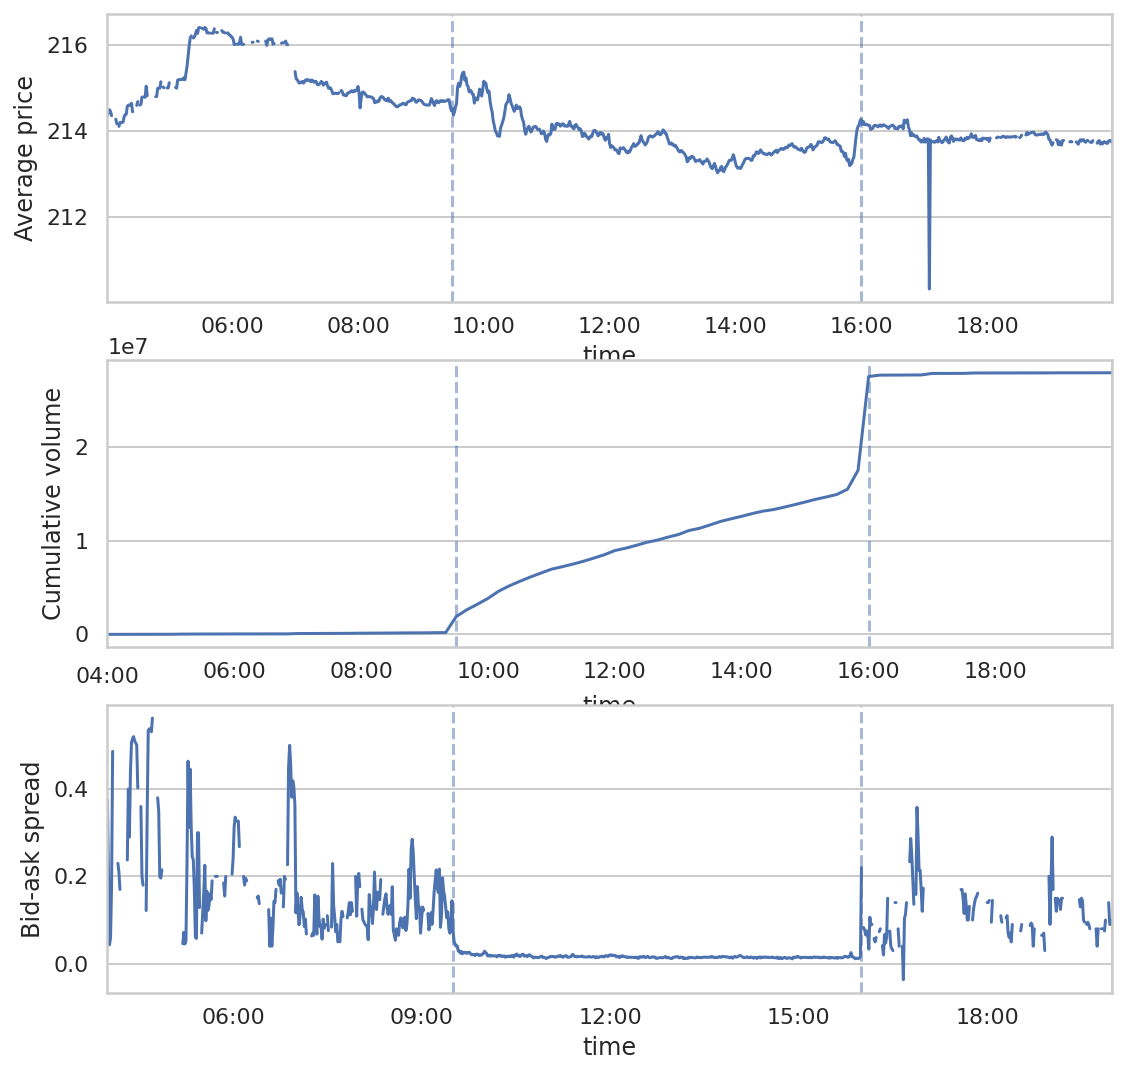

In [8]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 7)
trades = data.get_trades(ticker, date)
quotes = data.get_quotes(ticker, date)

fig, axes = plt.subplots(3, 1, figsize=(9, 9))
trades.groupby(pd.Grouper(key='time', freq='1min'))['price'].mean() \
    .plot.line(ax=axes[0], ylabel='Average price')
trades.groupby(pd.Grouper(key='time', freq='10min'))['volume'].sum().cumsum() \
    .plot.line(ax=axes[1], ylabel='Cumulative volume')
quotes.groupby(pd.Grouper(key='time', freq='1min'))['spread'].mean() \
    .plot.line(ax=axes[2], ylabel='Bid-ask spread')
for ax in axes:
    for time in [(9, 30), (16, 0)]:
        ax.axvline(
            datetime.datetime.combine(date, datetime.time(*time)), 
            linestyle='--', alpha=0.5
        )

The bid-ask spread outside of regular trading hours is ~10 times higher than during, making it riskier to perform transactions outside of trading hours. In addition, most shifts in price happen within hours, making it reasonable to focus on this time. 

### 2. When is a buy profitable?

Average bid-ask spread: 0.016518884597228233


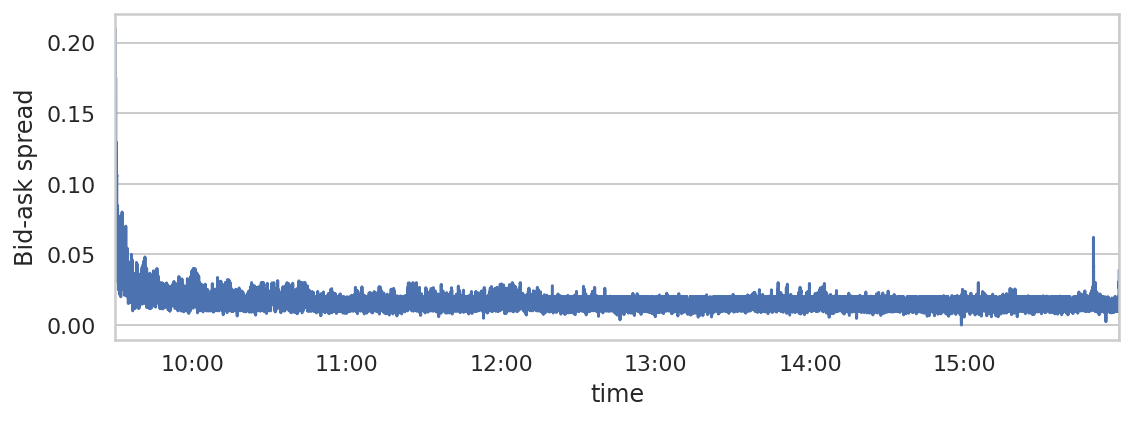

In [15]:
quotes = data.get_quotes('MSFT', '2020-12-07')

fig, ax = plt.subplots(figsize=(9, 3))
price = quotes.groupby(pd.Grouper(key='time', freq='1s'))['spread'].mean() \
    .between_time('09:30', '16:00', include_end=False)

price.plot.line(ax=ax, ylabel='Bid-ask spread')
print('Average bid-ask spread:', price.mean())

The average bid-ask spread is less than \\$0.03, meaning that the gain while the stock is owned has to be larger than \\$0.03 for it to be profitable. The exception is during the first minutes after trading starts. For now, that value can be used as a rough threshold, but, optimally, before performing any trade the actual current spread should be checked.

### 3. What time interval?

Average trades per second: 8.97371794871795


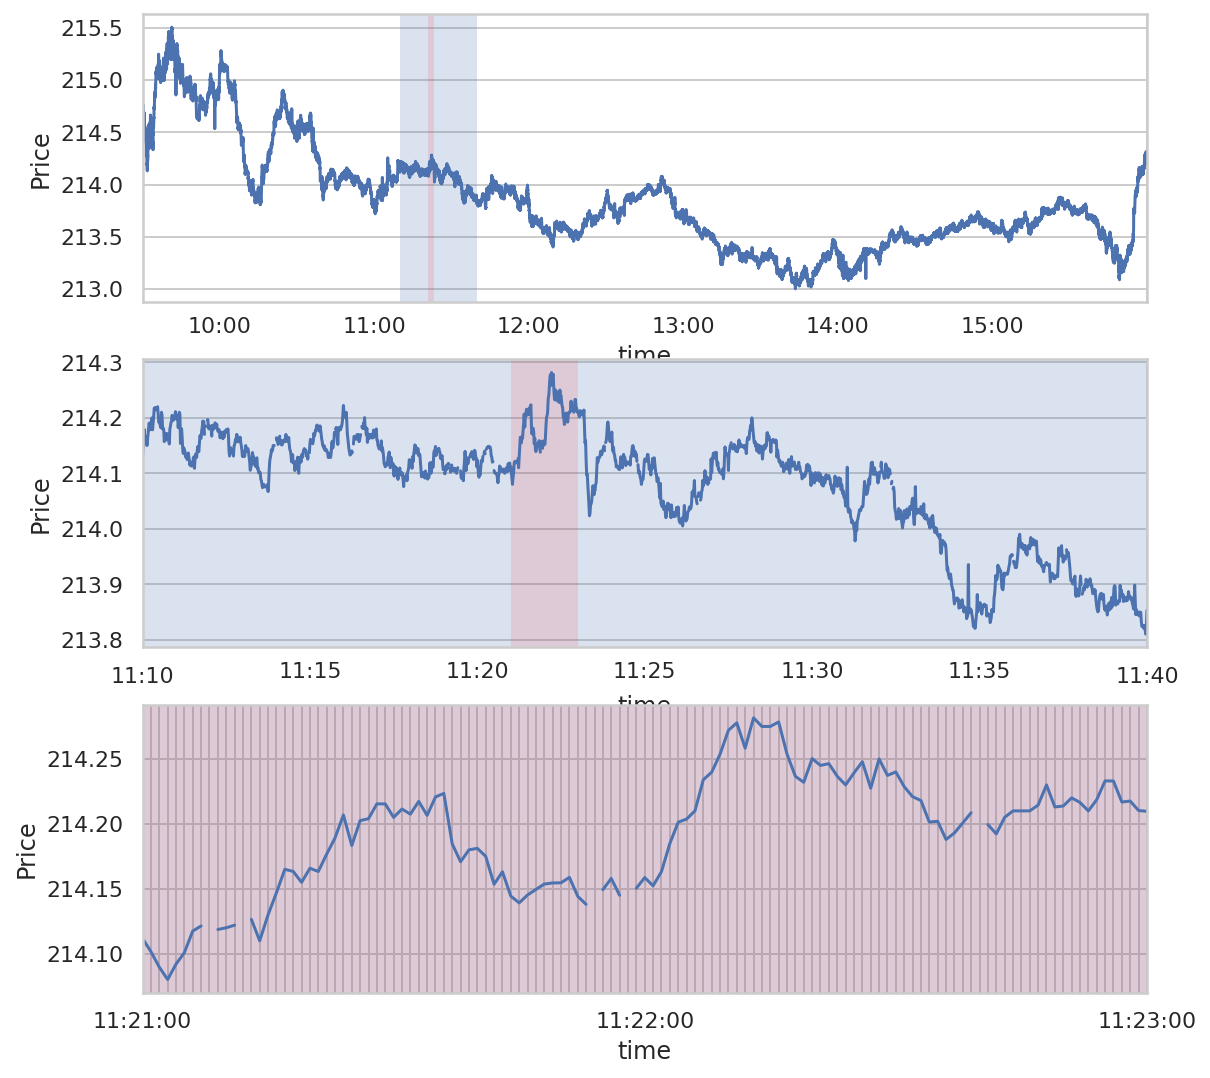

In [18]:
trades = data.get_trades('MSFT', '2020-12-07')

time_window = '1s' #'100ms'
grouper = pd.Grouper(key='time', freq=time_window)
price = trades.groupby(grouper)['price'].agg(['mean', 'count']) \
    .between_time('9:30', '16:00', include_end=False)

fig, axes = plt.subplots(3, 1, figsize=(9, 9))
price['mean'].plot.line(ax=axes[0], ylabel='Price')

window1 = price.between_time('11:10', '11:40')
window1['mean'].plot.line(ax=axes[1], ylabel='Price')

window2 = price.between_time('11:21', '11:23')
window2['mean'].plot.line(ax=axes[2], ylabel='Price')
axes[2].xaxis.set_major_locator(mpl.ticker.MultipleLocator(base=1.0))
    
for ax in axes:
    ax.axvspan(*window1.index[[0, -1]], alpha=0.2, lw=0)
    ax.axvspan(*window2.index[[0, -1]], color='red', alpha=0.1, lw=0)

print('Average trades per second:', price['count'].mean())

Prices swings exceeding the spread threshold happen often at the timescale of seconds. Most of the increases above the threshold happens over more than 10 seconds, making it unnecessary to capture nuances at a smaller interval than every second. 

## Target classification: when to buy and sell

Each timepoint should be classified as `buy`, `keep`, or `sell`:

- `buy`: The price is increasing, and it will increase enough to offset the transaction cost. The stock should be bought.
- `sell`: The price is decreasing. The stock should be sold.
- `keep`: The price is increasing, but not enough to buy. The stock should be kept if already bought.


Buys: 210
Active gain: 6.98%
Passive gain: -0.05%


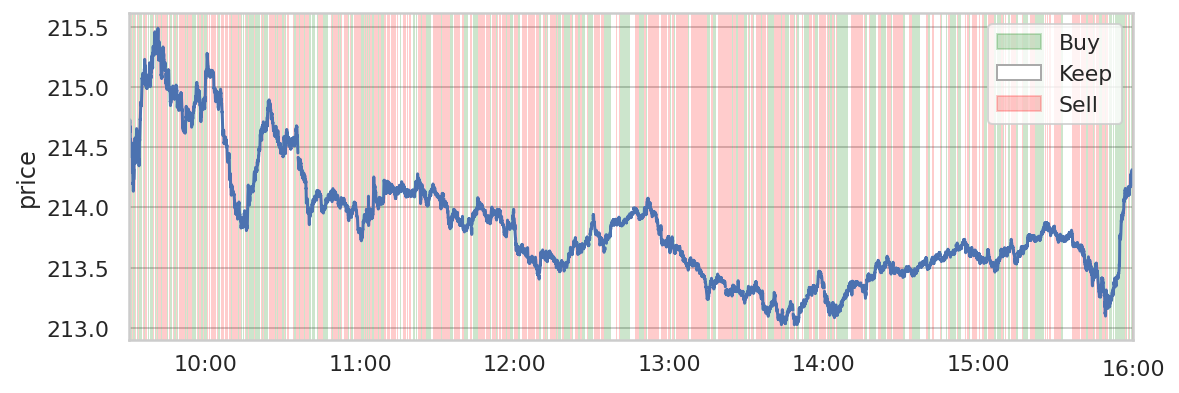

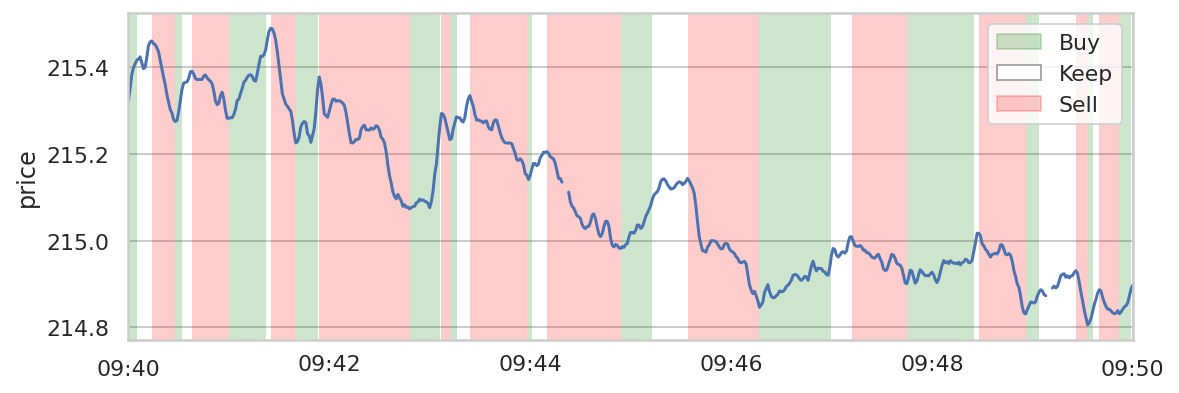

In [181]:
ticker = 'MSFT'
date = datetime.date(2020, 12, 7)

# How many period into the past should the current price be smoothed by to
# reduce low-level noise? More smoothing is less risky.
periods_to_smooth_price = 3

# How much, in dollars, does a stock have to gain while its held for the
# transaction to be profitable. A higher estimate is less risky.
gain_threshold = 0.05

# Get price aggregates per second.
price = data.get_bars(
    ticker, date, agg='weighted_mean', smooth_periods=periods_to_smooth_price
).rename('price').to_frame()

# Label long ups as buy, and long downs as sell.
price['prediction'] = target.label_buy_or_sell(
    ticker, date, {'periods_to_smooth_by': periods_to_smooth_price, 'gain_threshold': gain_threshold}
)

# Check hypothetical gains.
profits = target.profits(
    price['price'], price['prediction'], buy_cost=gain_threshold
)
print(f'Buys: {profits["total_buys"]}')
print(f'Active gain: {profits["active_gain"]*100:.2f}%')
print(f'Passive gain: {profits["passive_gain"]*100:.2f}%')

target.plot_timeseries(price, 'price')
target.plot_timeseries(price.between_time('9:40', '9:50'), 'price')

## Feature engineering

Features need to be generated for every second during open hours. All features are stored in the database, as they can take a while to generate. Features are generated one day at a time to allow caching of data shared by features.


### Initial features

- **Top recent trades**: For recent trades, get the top and bottom trades by price and volume. For these top trades, what are their price, volume, and how long ago did the trade happen? 
    
- **Trade stats of the current bar**: Descriptive stats of trades that happened during the most current time period (the last second). Includes the mean, median, min, max, and standard deviation of price, volume, and price-adjusted volume (price * volume).

- **Current bar compared to rolling average**: The relative changes in the mean, min, max, and std of the price and volume compared to a rolling average. The rolling average stretches from 3 seconds to the beginning of the day (but currently not any previous days).

- **Current price compared to previous high and low**: The relative change in the mean, min, and max price compared to the high and low of previous time windows, stretching from a minute to the beginning of the day (currently not any previous days).

- **Current price compared to the beginning of larger bars**: The relative change in the mean, min, and max price compared to the beginning of the minute, hour, day, and a few frequencies in between.

- **Trade stats of recent bars**: Descriptive stats of trades that happened during recent periods going back a defined number of seconds. Stats are normalized to the current bar.

- **Changes to stats of recent bars**: The change in stats for a defined number of recent bars compared to bar preceding it. 

- **Proportion of recent bars that increased**: The proportion of bars in a varied time window that increased in price, trade count, or volume (each considered separately). The time window spans from 1 second to the beginning of the day.

- **Number of consequtive bars that increased**: The number of consecutive bars into the past than increased in price, trade count, or volume (each considered separately) after applying a moving average smoothening. The time window spans from 1 second to 30 minutes.

- **Current time and date**: The second, minute, and hour of the day, as well the day of the week, month, quarter, and year.

- **Time since and until the beginning of a significant period**: The seconds since trading started for the day and until trading closes for the day (may be different on half-days after holidays), as well as the number of business days since the first and until the last business day of the month, quarter, and year.

- **Time since holiday**: The number days since the last holiday causing exchanges to be closed when it would have otherwise been open. Also includes whether a day is a half-day where the exchanges closes early due to a holiday (e.g. the day after Thanksgiving).

In [4]:
ticker = 'MSFT'
features = feature_manager.FeatureManager(ticker)

features.add_many([
    (
        'Target',
        target.label_buy_or_sell,
        {'gain_threshold': 0.05},
    ),
    (
        'Top recent trades',
        trade_properties.top_recent_trades,
        {'num_of_trades': 100, 'num_of_top_trades': 10},
    ), 
    (
        'Trade stats of the current bar',
        bar_properties.current_bar_stats,
    ), 
    (
        'Current bar compared to rolling average',
        bar_changes.current_bar_compared_to_rolling,
    ), 
    (
        'Current price compared to previous high and low',
        bar_changes.current_bar_compared_to_high_and_low,
    ), 
    (
        'Current price compared to the beginning of larger bars',
        bar_changes.current_bar_compared_to_open,
    ), 
    (
        'Trade stats of recent bars',
        bar_changes.recent_bars_compared_to_current,
        {'periods_to_go_back': 60},
    ), 
    (
        'Changes to stats of recent bars',
        bar_changes.recent_bars_compared_to_preceding,
        {'periods_to_go_back': 60},
    ), 
    (
        'Proportion of recent bars that increased',
        bar_changes.proportion_of_increasing_bars,
    ), 
    (
        'Number of consequtive bars that increased',
        bar_changes.consecutive_of_increasing_bars,
    ), 
    (
        'Current time and date',
        times.current_time_and_date,
    ), 
    (
        'Time since and until the beginning of a significant period',
        times.time_since_and_until_start_of,
    ), 
    (
        'Time since holiday',
        times.time_since_holiday,
    )
])
with utils.timer():
    features.generate('2020-01-01', '2020-12-31')

11:53:14 The 13 features(s) are already stored for 2020-01-01 to 2020-12-31.
11:53:14 Feature generation completed.
Time: 0.38s


### Addition feature ideas

- Technical indicators.
- Comparing prices/volumes across different days.
- Stats on quotes.
- Relevant news articles.
- Mentions on social networks.

## Hyperparameter tuning

The best hyperparameters are searched for by first using a random approach to sample hyperparameter space, and then performing a more thorough grid search. 

### Initial randomized parameter search
The data is sampled to one month of trades for training the model, ensuring everything can fit in memory. To decrease bias towards the sample, three models are trained of three different time periods for each parameter set. Each model is tested on the business day following the training period.

In [2]:
ticker = 'MSFT'

number_of_iterations = 10
number_of_cross_validations = 3

model_path = 'models/random_search'

training_dates = [
    ('2020-03-01', '2020-03-31'),
    ('2020-09-09', '2020-10-08'),
    ('2020-11-28', '2020-12-27')
]
test_dates = ['2020-04-01', '2020-10-09', '2020-12-28']

@functools.lru_cache(maxsize=1)
def get_train(cv):
    df = data.get_features(ticker, *training_dates[cv])
    return df.iloc[:, 1:], df.iloc[:, 0]

@functools.lru_cache(maxsize=1)
def get_test(cv):
    df = data.get_features(ticker, test_dates[cv])
    return df.iloc[:, 1:], df.iloc[:, 0]
        
def get_base_model(params):
    return sklearn.ensemble.RandomForestClassifier(
        n_jobs=15, random_state=1, criterion='gini', max_features='sqrt', 
        bootstrap=True, **params
    )

param_grid = {
    'max_depth': [20, 50, 100, 200],
    'min_samples_leaf': [2, 5, 10, 20, 50],
    'min_samples_split': [10, 20, 50, 100, 200],
    'max_samples': [0.1, 0.2, 0.5, None],
    'n_estimators': [20, 50, 100, 200],
}

# Randomize parameters
random.seed(0)
random_params = [{}]  # first model is base model
for i in range(number_of_iterations-1):
    params = {}
    while params in random_params:
        for param_name, param_values in sorted(param_grid.items()):  # sort to ensure random consistency
            params[param_name] = random.choice(param_values)
    random_params.append(params)

# Fit and save model.
for cv in range(number_of_cross_validations):  #cv in outer loop to allow caching of data
    for i in range(number_of_iterations):
        params = random_params[i]
        model_name = f'{i}_{cv}_' + '_'.join([f'{k}_{v}' for k, v in sorted(params.items())])
        if os.path.exists(f'{model_path}/{model_name}.pkl'):
            continue
        logging.info(f'Fitting: CV {cv}, iteration {i}, {params}')
        model = get_base_model(params)
        model.fit(*get_train(cv))
        joblib.dump(model, f'{model_path}/{model_name}.pkl')
        del model
        
get_train.cache_clear()
get_test.cache_clear()
print('Parameter search complete.')

Parameter search complete.


### Analysis of initial randomized parameter search

In [3]:
random_search_results = {}
for cv in range(number_of_cross_validations):
    logging.info('Caching data')
    get_train(cv), get_test(cv)
    for i in range(number_of_iterations):
        params = random_params[i]
        logging.info(f'Testing: CV {cv}, iteration {i}, {params}')
        
        model_name = f'{i}_{cv}_' + '_'.join([f'{k}_{v}' for k, v in sorted(params.items())])
        model = joblib.load(f'{model_path}/{model_name}.pkl')
        
        result = random_search_results.get(i, {
            'names': [], 'params': params, 'train_scores': [], 'test_scores': []
        })
        result['names'].append(model_name)
        for train_or_test, get_data in [('train', get_train), ('test', get_test)]:
            result[f'{train_or_test}_scores'].append(
                sklearn.metrics.f1_score(
                    get_data(cv)[1], 
                    model.predict(get_data(cv)[0]), 
                    average='weighted'
                )
            )
        random_search_results[i] = result
    
    del model
    get_train.cache_clear()
    get_test.cache_clear()

00:19:39 Caching data
00:19:56 Testing: CV 0, iteration 0, {}
00:20:30 Testing: CV 0, iteration 1, {'max_depth': 200, 'max_samples': None, 'min_samples_leaf': 2, 'min_samples_split': 50, 'n_estimators': 200}
00:21:12 Testing: CV 0, iteration 2, {'max_depth': 200, 'max_samples': 0.5, 'min_samples_leaf': 20, 'min_samples_split': 50, 'n_estimators': 50}
00:21:24 Testing: CV 0, iteration 3, {'max_depth': 50, 'max_samples': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
00:21:47 Testing: CV 0, iteration 4, {'max_depth': 50, 'max_samples': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
00:22:07 Testing: CV 0, iteration 5, {'max_depth': 200, 'max_samples': 0.1, 'min_samples_leaf': 10, 'min_samples_split': 100, 'n_estimators': 100}
00:22:20 Testing: CV 0, iteration 6, {'max_depth': 50, 'max_samples': None, 'min_samples_leaf': 20, 'min_samples_split': 200, 'n_estimators': 100}
00:22:36 Testing: CV 0, iteration 7, {'max_depth': 20, 'max_sampl

In [4]:
base_model = results[0]
best_model = base_model
for model in random_search_results.values():
    if np.mean(model['test_scores']) > np.mean(best_model['test_scores']):
        best_model = model

print(
    f'Base model - {base_model["params"]}\n'
    f'train scores: {base_model["train_scores"]}\n'
    f'test scores: {base_model["test_scores"]}'
)
print(
    f'Best random model - {best_model["params"]}\n'
    f'train scores: {best_model["train_scores"]}\n'
    f'test scores: {best_model["test_scores"]}'
)

for i, name in enumerate(best_model['names']):
    shutil.copyfile(f'{model_path}/{name}.pkl', f'{model_path}/best_model_{i}.pkl')

Base model - {}
train scores: [0.9999961151573231, 0.9999980575782785, 0.9999953897830793]
test scores: [0.5817024722389664, 0.4976963015082763, 0.48489304089332086]
Best random model - {'max_depth': 200, 'max_samples': 0.5, 'min_samples_leaf': 5, 'min_samples_split': 50, 'n_estimators': 20}
train scores: [0.7286618468418813, 0.7321245538246993, 0.7321557013556482]
test scores: [0.5818379904121465, 0.4988952525819703, 0.49272165925296896]



:: 2020-04-01 :: 
Passive gain: -0.58% 
Possible active gain: 62.92% (690 buys) 
Predicted active gain: -13.05% (2486 buys) 

Optimal:


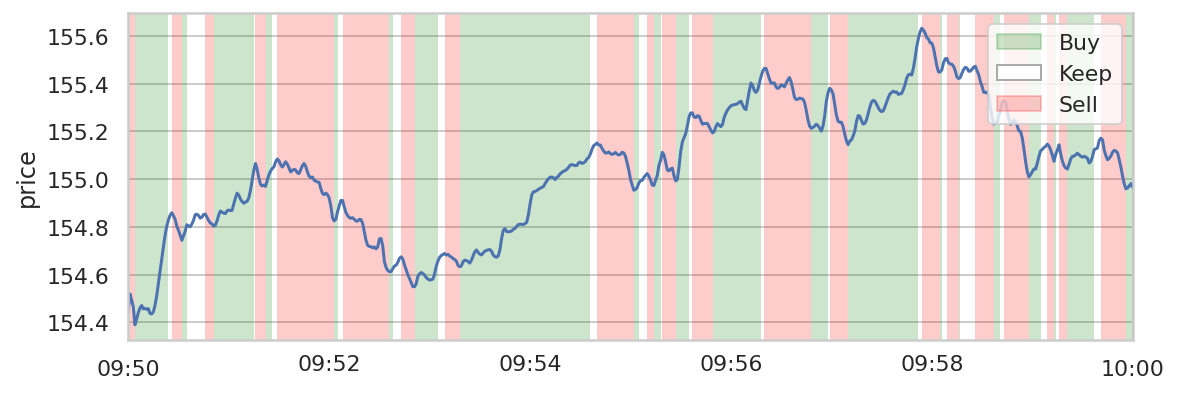

Predicted:


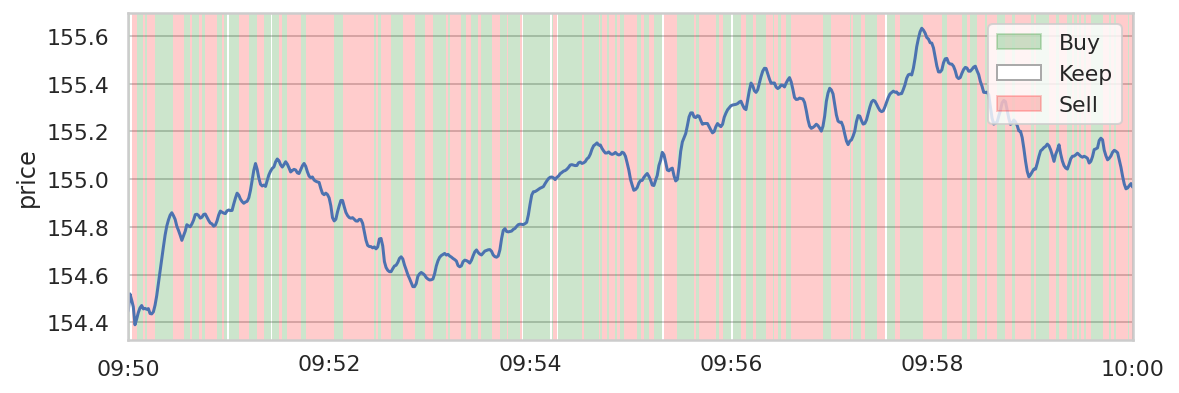


:: 2020-12-28 :: 
Passive gain: 0.26% 
Possible active gain: 6.97% (230 buys) 
Predicted active gain: -22.93% (1875 buys) 

Optimal:


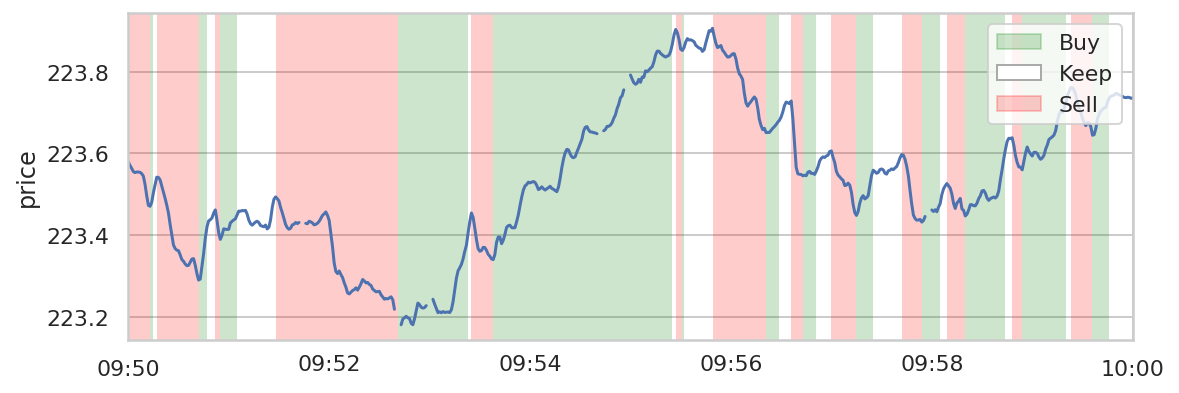

Predicted:


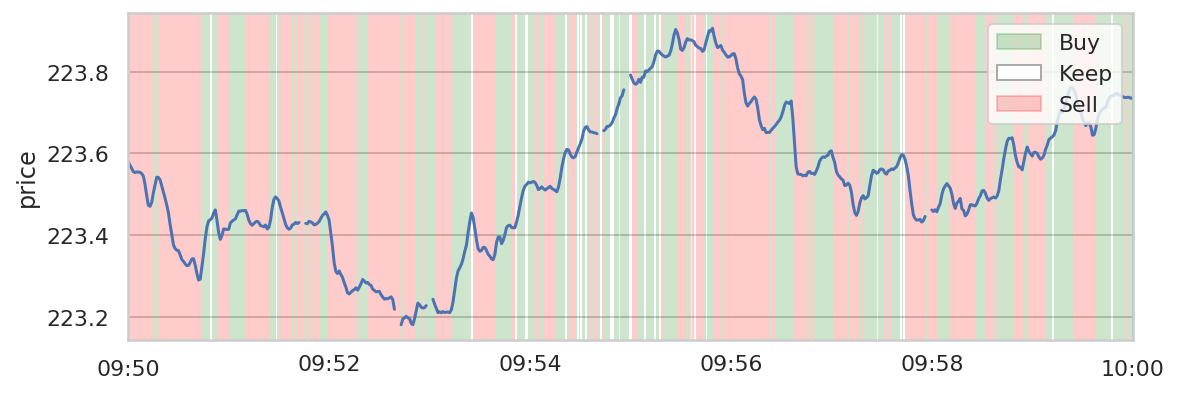

In [5]:
for cv in [0, 2]:
    test_date = test_dates[cv]
    model = joblib.load(f'{model_path}/best_model_{cv}.pkl')

    df = data.get_bars(
        ticker, test_date, agg='weighted_mean', smooth_periods=3
    ).rename('price').to_frame()

    df['prediction'] = model.predict(get_test(cv)[0])
    df['actual'] = get_test(cv)[1]

    profits_actual = target.profits(df['price'], df['actual'], buy_cost=0.05)
    profits_prediction = target.profits(df['price'], df['prediction'], buy_cost=0.05)
    print(
        f'\n:: {test_date} :: \n'
        f'Passive gain: {profits_actual["passive_gain"]*100:.2f}% \n'
        f'Possible active gain: {profits_actual["active_gain"]*100:.2f}% '
        f'({profits_actual["total_buys"]} buys) \n'
        f'Predicted active gain: {profits_prediction["active_gain"]*100:.2f}% '
        f'({profits_prediction["total_buys"]} buys) \n'
    )
    print('Optimal:')
    target.plot_timeseries(df.between_time('9:50', '10:00'), 'price', 'actual')
    print('Predicted:')
    target.plot_timeseries(df.between_time('9:50', '10:00'), 'price', 'prediction')

Looking at the buy-sell plot, some periods are correctly predicted, which is promising. However, these periods are frequently interrupted short break, resulting in many more buys than what is optimal.

More concerning is that both the base model _and_ the optimal model from the randomized hyperparameter search are significantly overfit, performing perfectly on the training set and equally bad on the test set. Which hyperparameters have the potential to reduce the fit on the training data without negatively affecting the git on the test data?

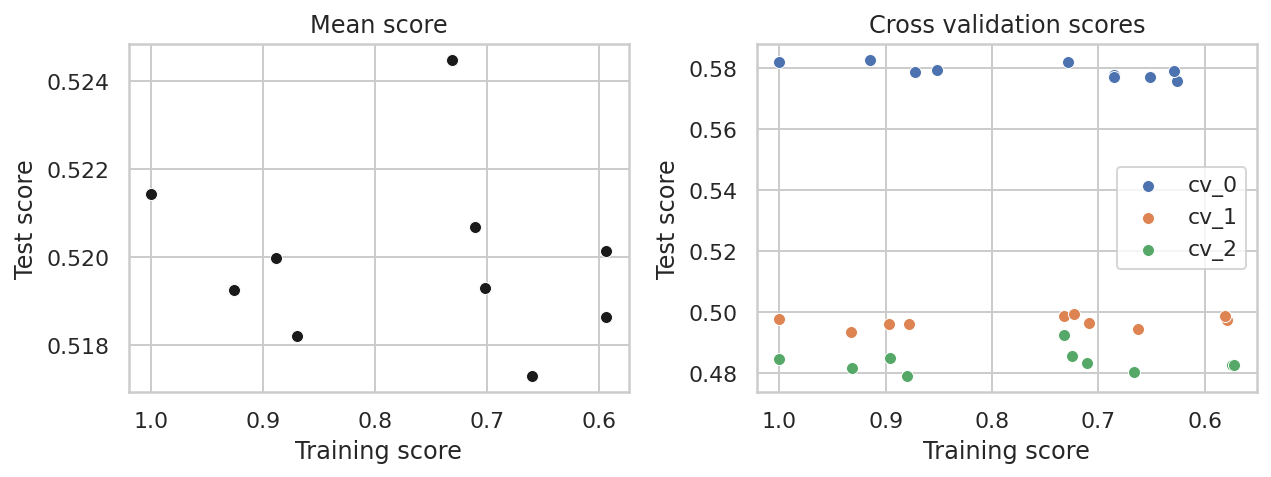

In [13]:
df_rows = []
for _, result in sorted(random_search_results.items()):
    df_rows.append({
        'mean_train_score': np.mean(result['train_scores']),
        'mean_test_score': np.mean(result['test_scores']),
        **{f'train_{i}': score for i, score in enumerate(result['train_scores'])},
        **{f'test_{i}': score for i, score in enumerate(result['test_scores'])},
        **result['params'],
    })
search_results_df = pd.DataFrame(df_rows)
    
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
sns.scatterplot(
    ax=axes[0], data=search_results_df, x='mean_train_score', y='mean_test_score', color='k'
)
for cv in range(3):
    sns.scatterplot(
        ax=axes[1], data=search_results_df, x=f'train_{cv}', y=f'test_{cv}',
        label=f'cv_{cv}'
    )
axes[0].set_title('Mean score')
axes[1].set_title('Cross validation scores')
for ax in axes:
    ax.invert_xaxis()
#     ax.set_ylim(0.46, 0.57)
    ax.set_ylabel('Test score')
    ax.set_xlabel('Training score')
fig.tight_layout()

The hyperparameter results in training scores down to 0.7 without significanly impacting test scores. These parameters will serve as a base for another round of randomized hyperparameter search.

Furthermore, a large variation is seen in tests scores for different cross validation rounds. Since each round consists of a different training data size, it is likely that the training data is a limiting factor. The round with the most training data performed the best. As not more training data fits compfortably in the memory, it will have to be loaded directly from disk as the forest is built.

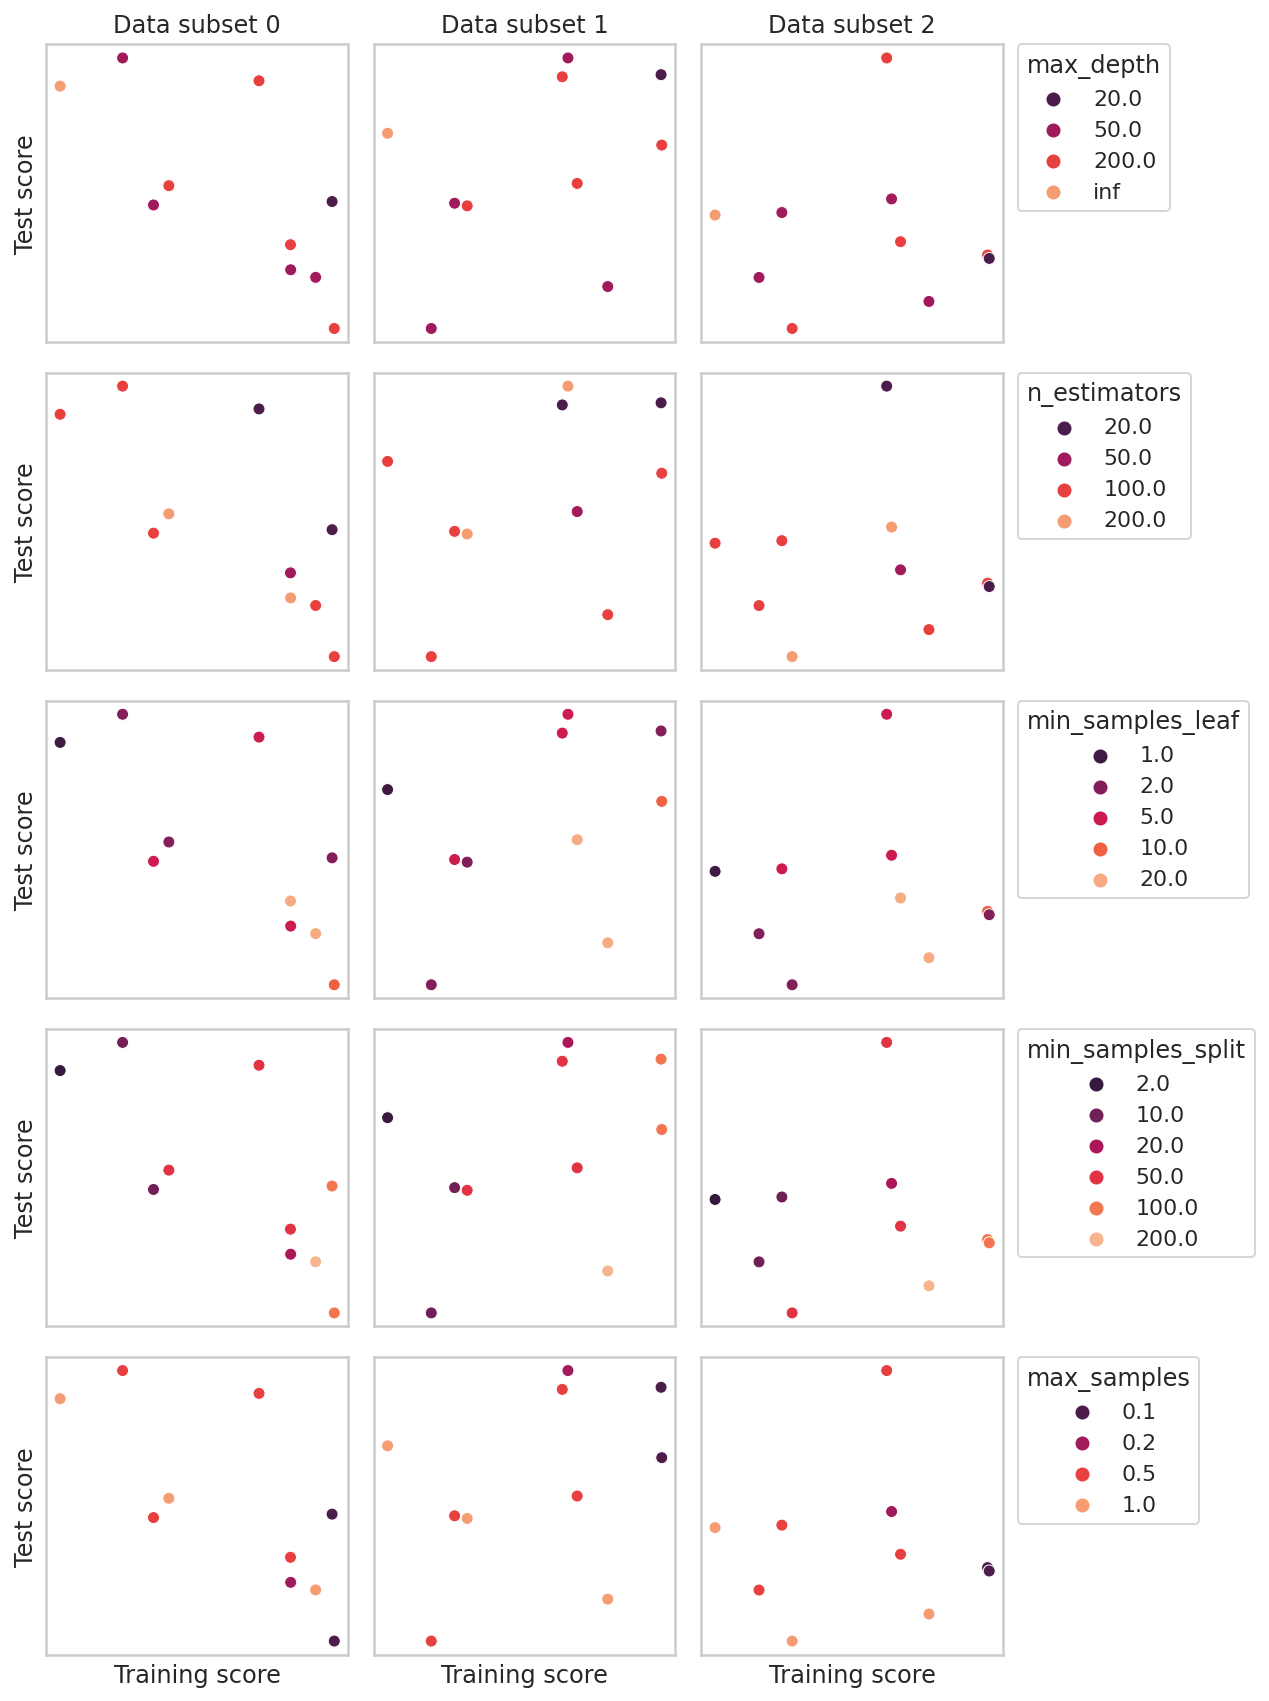

In [53]:
fig, axes = plt.subplots(5, 3, figsize=(9, 12))
axes = axes.flatten()
parameters = ['max_depth', 'n_estimators', 'min_samples_leaf', 'min_samples_split', 'max_samples']

# Set detault parameters for visualization.
search_results_df.loc[0, 'max_depth'] = np.inf
search_results_df.loc[0, 'n_estimators'] = 100
search_results_df.loc[0, 'min_samples_leaf'] = 1
search_results_df.loc[0, 'min_samples_split'] = 2
search_results_df['max_samples'] = search_results_df['max_samples'].fillna(1)

i = 0
sns.color_palette("rocket", as_cmap=True)
for parameter in parameters:
    hue = search_results_df[parameter].astype(str)
    for cv in range(3):
        sns.scatterplot(
            ax=axes[i], data=search_results_df, x=f'train_{cv}', y=f'test_{cv}',
            hue=hue, 
            hue_order=sorted(hue.unique(), key=lambda x: float(x if x != 'nan' else -1)),
            legend=('auto' if cv == 2 else False), palette='rocket'
        )
        i += 1

for i, ax in enumerate(axes):
    ax.invert_xaxis()
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel('Test score' if i % 3 == 0 else '')
    ax.set_xlabel('Training score' if i > 11 else '')
    if i % 3 == 2:
        ax.legend(title=parameters[i // 3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    if i < 3:
        ax.set_title(f'Data subset {i}')

fig.tight_layout()

From the third cross-validation, the best-performing parameters are `maxdepth = 50`, `min_samples_leaf = 5`, and `min_samples_split = 100`. The second round of randomized parameter search will center on these values.

### Determining calendar trends in model prediction performance

In [ ]:

all_days = pd.date_range('2020-01-01', '2020-12-31')
days = np.random.choice(all_days, 500)
events = pd.Series(np.random.randn(len(days)), index=days)
calplot.calplot(events)

### Grid search to optimize hyperparameters

Index(['current_price_compared_to_previous_high_and_low__1D_low_price_max',
       'proportion_of_recent_bars_that_increased__1D_price_inc_sign',
       'current_bar_compared_to_rolling_average__30min_price',
       'current_price_compared_to_the_beginning_of_larger_bars__open_1H_price',
       'proportion_of_recent_bars_that_increased__10min_count_inc_sign',
       'current_price_compared_to_previous_high_and_low__30min_high_price_max',
       'proportion_of_recent_bars_that_increased__30min_count_inc_sign',
       'current_price_compared_to_previous_high_and_low__30min_low_price_max',
       'current_price_compared_to_previous_high_and_low__1H_low_price',
       'current_price_compared_to_the_beginning_of_larger_bars__open_5min_price_min',
       'current_price_compared_to_previous_high_and_low__5min_low_price_max',
       'current_price_compared_to_previous_high_and_low__1min_low_price',
       'current_bar_compared_to_rolling_average__5min_price',
       'trade_stats_of_recent_bars

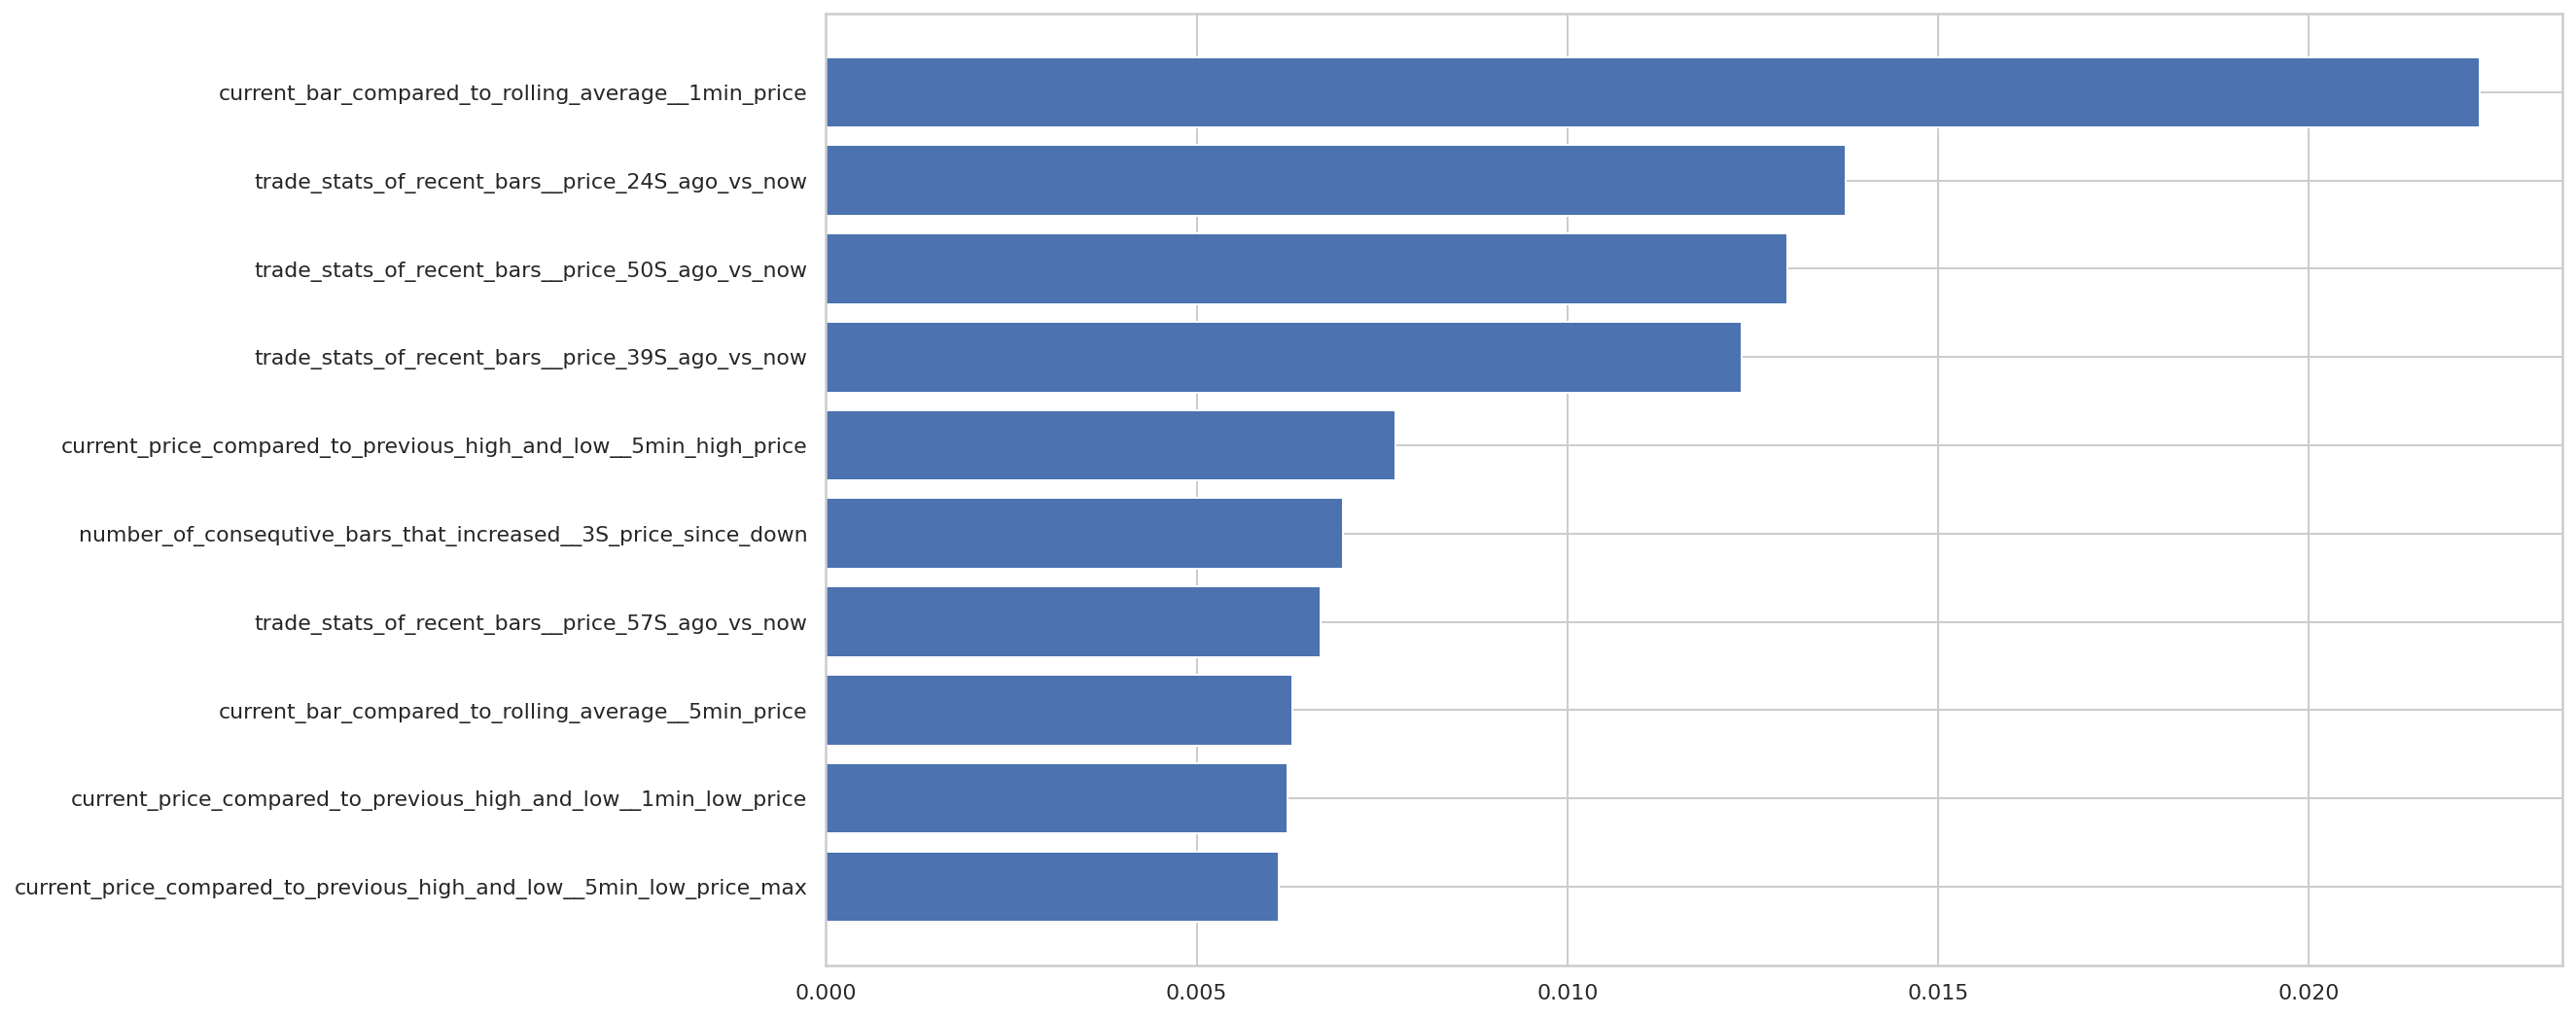

In [147]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(train_X.columns[sorted_idx][-10:], model.feature_importances_[sorted_idx][-10:])
print(train_X.columns[sorted_idx][-20:])

In [ ]:

#https://github.com/dmlc/xgboost/issues/1686